In [2]:
import numpy as np
import pandas as pd
import os
import csv
import logging
import random
import pickle


class CelebA(object):
    FILENAME_LABELS = 'list_attr_celeba.txt'
    TMP_TRAIN_LABELS = 'celeba_ytrain.dat'
    TMP_TEST_LABELS = 'celeba_ytest.dat'
    TMP_TRAIN_FILES = 'celeba_imgs_train'
    TMP_TEST_FILES = 'celeba_imgs_test'

    def as_numpy_array(self, projection=['Smiling'], train_proportion=0.8, imbalance_proportion=None, oversample=False,
                       filter_by=None, cache=True):
        tmp_train_labels = os.path.join(self.cache_dir, self.TMP_TRAIN_LABELS)
        tmp_test_labels = os.path.join(self.cache_dir, self.TMP_TEST_LABELS)
        tmp_train_fnames = os.path.join(self.cache_dir, self.TMP_TRAIN_FILES)
        tmp_test_fnames = os.path.join(self.cache_dir, self.TMP_TEST_FILES)

        if all([os.path.exists(f) for f in
                [tmp_train_labels, tmp_test_labels, tmp_train_fnames,
                 tmp_test_fnames]]) and cache:
            y_train_memmap = pickle.load(open(tmp_train_labels, "rb"))
            y_test_memmap = pickle.load(open(tmp_test_labels, "rb"))
            fnames_train_memmap = pickle.load(open(tmp_train_fnames, "rb"))
            fnames_test_memmap = pickle.load(open(tmp_test_fnames, "rb"))
        else:
            labels_path = os.path.join(self.dir_imgs, self.FILENAME_LABELS)
            with open(labels_path) as f:
                reader = csv.reader(f)
                next(reader)
                label_names = next(reader)[0].split(' ')[:-1]
                columns = ['image'] + label_names

            index = pd.read_csv(labels_path, delim_whitespace=True, skiprows=2, names=columns)
            num = index._get_numeric_data()
            num[num < 0] = 0
            index = index.sample(frac=1).reset_index(drop=True)

            negatives = index[index[projection[0]] == 0].index.tolist()
            positives = index[index[projection[0]] > 0].index.tolist()
            if imbalance_proportion == 1.0:
                imbalance_proportion = None # Hacky hack
            drop_size = len(positives) - int(len(negatives) * imbalance_proportion) if imbalance_proportion else 0

            assert (drop_size >= 0), "Not enough positive samples to fulfill imbalance ratio requirement."

            imbalanced_index = index.drop(positives[:drop_size])

            row_count = len(imbalanced_index.index)
            test_size = int(row_count * (1 - train_proportion))
            test_idxs = np.random.choice(imbalanced_index.index.tolist(), test_size, replace=False)

            imbalanced_index['image'] = imbalanced_index['image'].apply(lambda path: os.path.join(self.dir_imgs, path))

            y_train = imbalanced_index[projection].drop(test_idxs)
            train_fnames = imbalanced_index['image'].drop(test_idxs)
            y_test = imbalanced_index[projection].loc[test_idxs]
            test_fnames = imbalanced_index['image'].loc[test_idxs]

            y_train_memmap, fnames_train_memmap = CelebA._to_cache(tmp_train_labels,
                                                                   tmp_train_fnames, y_train,
                                                                   train_fnames, cache)
            y_test_memmap, fnames_test_memmap = CelebA._to_cache(tmp_test_labels,
                                                                 tmp_test_fnames, y_test,
                                                                 test_fnames, cache)

        if oversample:
            fnames_train_memmap, y_train_memmap = self.oversample(fnames_train_memmap, np.squeeze(y_train_memmap))
            y_train_memmap = np.expand_dims(y_train_memmap, axis=1)

        if filter_by is not None:
            keep_idx = filter_by(fnames_train_memmap, y_train_memmap)
            fnames_train_memmap = fnames_train_memmap[keep_idx]
            y_train_memmap = y_train_memmap[keep_idx]

        p = np.random.permutation(len(fnames_train_memmap))
        y_test_holdout = np.array_split(y_test_memmap, 2)
        fnames_test_holdout = np.array_split(fnames_test_memmap, 2)

        return y_train_memmap[p], fnames_train_memmap[p], y_test_holdout[0], fnames_test_holdout[0], y_test_holdout[1], \
               fnames_test_holdout[1]

    def oversample(self, X_train, y_train):
        selected_indices = np.where(y_train == 1)
        sample_size = y_train.shape[0] - 2 * selected_indices[0].shape[0]
        oversampled_indices = np.random.choice(selected_indices[0], sample_size)
        return np.concatenate((X_train, X_train[oversampled_indices])), \
               np.concatenate((y_train, y_train[oversampled_indices]))

    @staticmethod
    def _to_cache(tmp_labels_path, tmp_imgs_path, y, imgs, cache):
        y = np.array(y)
        imgs = np.array(imgs)

        if cache:
            pickle.dump(y, open(tmp_labels_path, "wb+"))
            pickle.dump(imgs, open(tmp_imgs_path, "wb+"))

        return y, imgs

    def __init__(self, dir_prefix, cache_dir, grayscale=False):
        '''
        Constructor
        '''
        self.logger = logging.getLogger(__name__)
        self.cache_dir = cache_dir
        if cache_dir and not os.path.isdir(cache_dir):
            os.makedirs(cache_dir)
            self.logger.info("Creating cache directory at %s" % os.path.abspath(self.cache_dir))
        self.c_dim = 1 if grayscale else 3
        self.dir_imgs = dir_prefix
        self.width = 178
        self.height = 218
        if not os.path.isdir(self.dir_imgs):
            self.logger.warning("Image directory does not exist (%s)" % self.dir_imgs)

In [3]:
dataset = CelebA(dir_prefix="./img_align_celeba",
                 cache_dir="./cache")
data_y, data, _, _, _, _ = dataset.as_numpy_array(imbalance_proportion=0.25,
                                                  projection=["Smiling"])


In [4]:
from __future__ import division
import math
import json
import random
import pprint
import scipy.misc
import numpy as np
from time import gmtime, strftime
from six.moves import xrange

def get_image(image_path, input_height, input_width,
              resize_height=64, resize_width=64,
              is_crop=True, is_grayscale=False):
  image = imread(image_path, is_grayscale)
  return transform(image, input_height, input_width,
                   resize_height, resize_width, is_crop)

def transform(image, input_height, input_width, 
              resize_height=64, resize_width=64, is_crop=True):
  if is_crop:
    cropped_image = center_crop(
      image, input_height, input_width, 
      resize_height, resize_width)
  else:
    cropped_image = scipy.misc.imresize(image, [resize_height, resize_width])
  return np.array(cropped_image)/127.5 - 1.

def imread(path, is_grayscale = False):
  if (is_grayscale):
    return scipy.misc.imread(path, flatten=True).astype(np.float)
  else:
    return scipy.misc.imread(path).astype(np.float)

In [5]:
from glob import glob

sample_size = 1000
sample_files = data[0:sample_size]
sample = [
    get_image(sample_file,
              input_height=218,
              input_width=178,
              resize_height=109,
              resize_width=89,
              is_crop=False,
              is_grayscale=False) for sample_file in sample_files]

gen_data = glob(os.path.join("./cache_generated", "xgenerated_*"))
gen_sample_files = gen_data[0:sample_size]
sample_gen = [
    get_image(sample_file,
              input_height=109,
              input_width=89,
              resize_height=109,
              resize_width=89,
              is_crop=False,
              is_grayscale=False) for sample_file in gen_sample_files]

sample = sample + sample_gen

In [49]:
import umap
%matplotlib inline
embedding = umap.UMAP().fit_transform(np.reshape(sample, (sample_size*2, -1)))

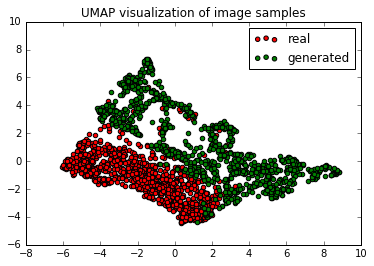

In [56]:
colors = ["r" if i < sample_size else "g" for i, s in enumerate(sample)]

plt.scatter(embedding[:sample_size, 0], embedding[:sample_size, 1], c="r", label="real")
plt.scatter(embedding[sample_size+1:, 0], embedding[sample_size+1:, 1], c="g", label="generated")
plt.legend()
plt.title("UMAP visualization of image samples")
plt.show()